In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from timm.models import create_model
from torchvision import transforms
from visualizer_utils import visualize_filters, visualize_activations, pre_transforms
import pyramid_vig
import vig
import torch
from PIL import Image
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [6]:
model = 'pvig_ti_224_gelu'
pretrained = False
num_classes = 1000
drop = 0
drop_connect = None
drop_path= 0.1
drop_block = None
global_pool = None
bn_tf=False
bn_momentum=None
bn_eps=None
initial_checkpoint=None
device = 'cuda:1'

In [ ]:
model = create_model(
    model,
    pretrained=pretrained,
    num_classes=num_classes,
    drop_rate=drop,
    drop_connect_rate=drop_connect,  # DEPRECATED, use drop_path
    drop_path_rate=drop_path,
    drop_block_rate=drop_block,
    global_pool=global_pool,
    bn_tf=bn_tf,
    bn_momentum=bn_momentum,
    bn_eps=bn_eps,
    checkpoint_path=initial_checkpoint)
model.to(device)
clear_output(wait=True)

In [5]:
pretrain_path = 'pvig_ti_78.5.pth.tar'
print('Loading:', pretrain_path)
state_dict = torch.load(pretrain_path)
model.load_state_dict(state_dict, strict=False)
print('Pretrain weights loaded.')
model.eval()
clear_output(wait=True)

Loading: pvig_ti_78.5.pth.tar
Pretrain weights loaded.


In [6]:
img_path = 'fig/ILSVRC2012_val_00000075.JPEG'
img = Image.open(img_path).resize((224, 224))

In [7]:
img_data = torch.unsqueeze(pre_transforms(img), 0).to(device)
output = model(img_data)
index = torch.argmax(output)
print('Predicted class:', index)

Predicted class: tensor(80, device='cuda:0')


In [ ]:
from imagenet_id2name import imageNet_id2name
plt.title("Predicted label: " + imageNet_id2name[index.item()], color="red")
plt.imshow(np.squeeze(img))
plt.axis('off')

In [ ]:
# for k, v in model.named_parameters():
#     print(k, v.shape)

Visualizing 


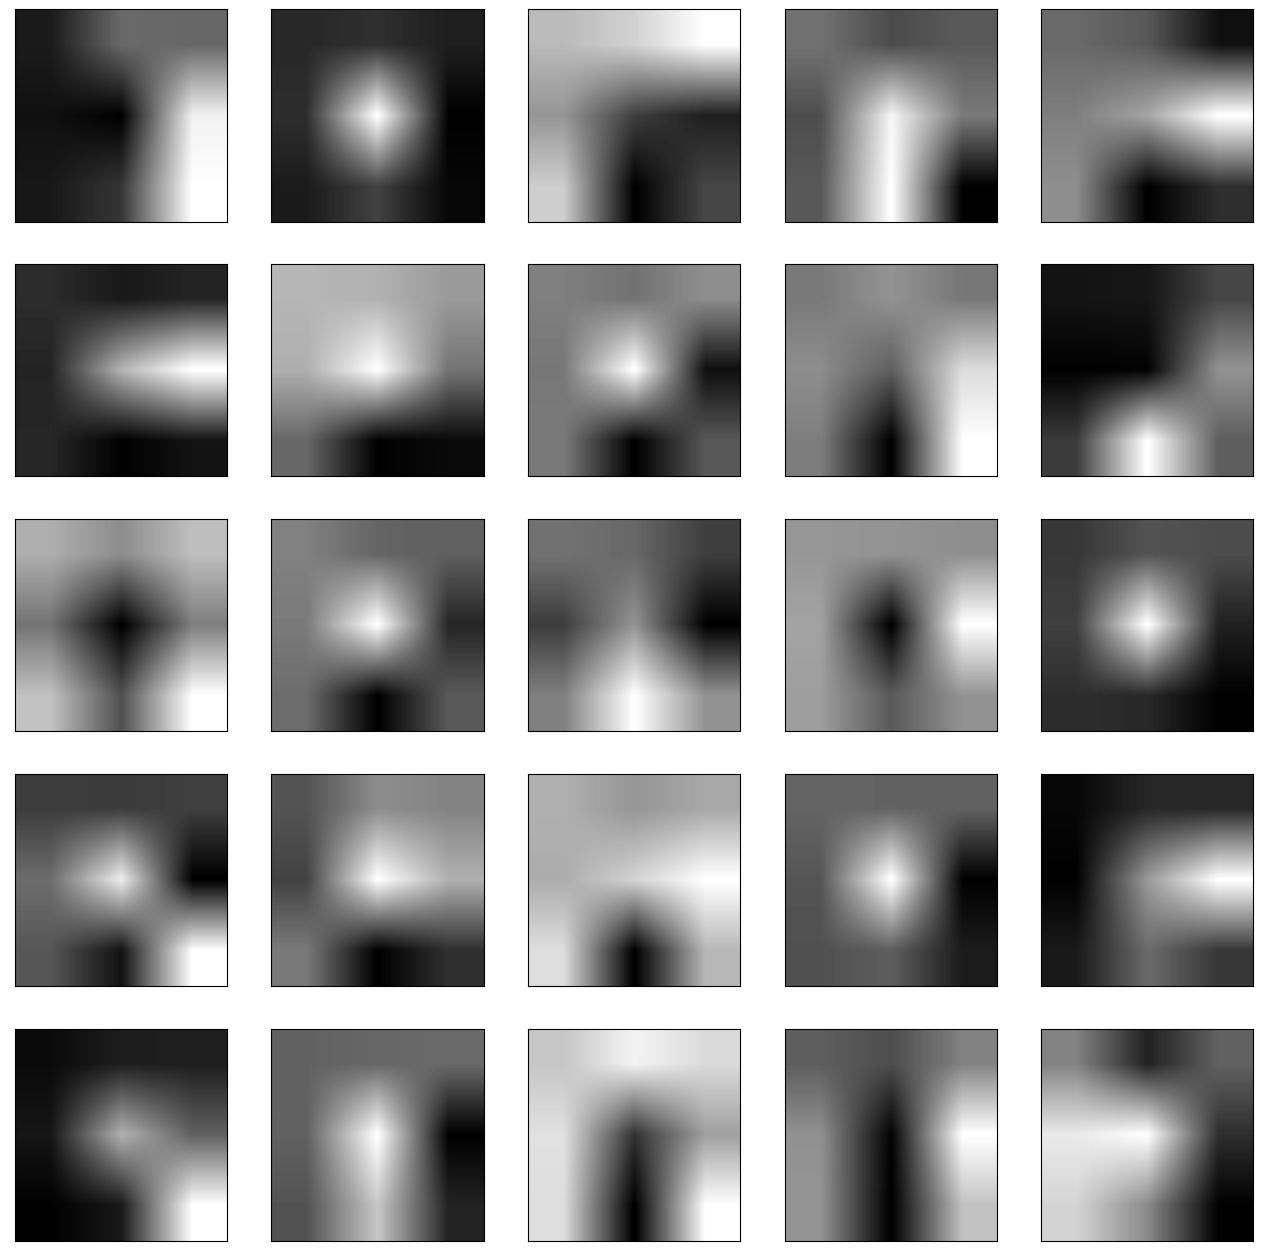

In [9]:
visualize_filters(model, 'stem.convs.6.weight', max_filters = 25)

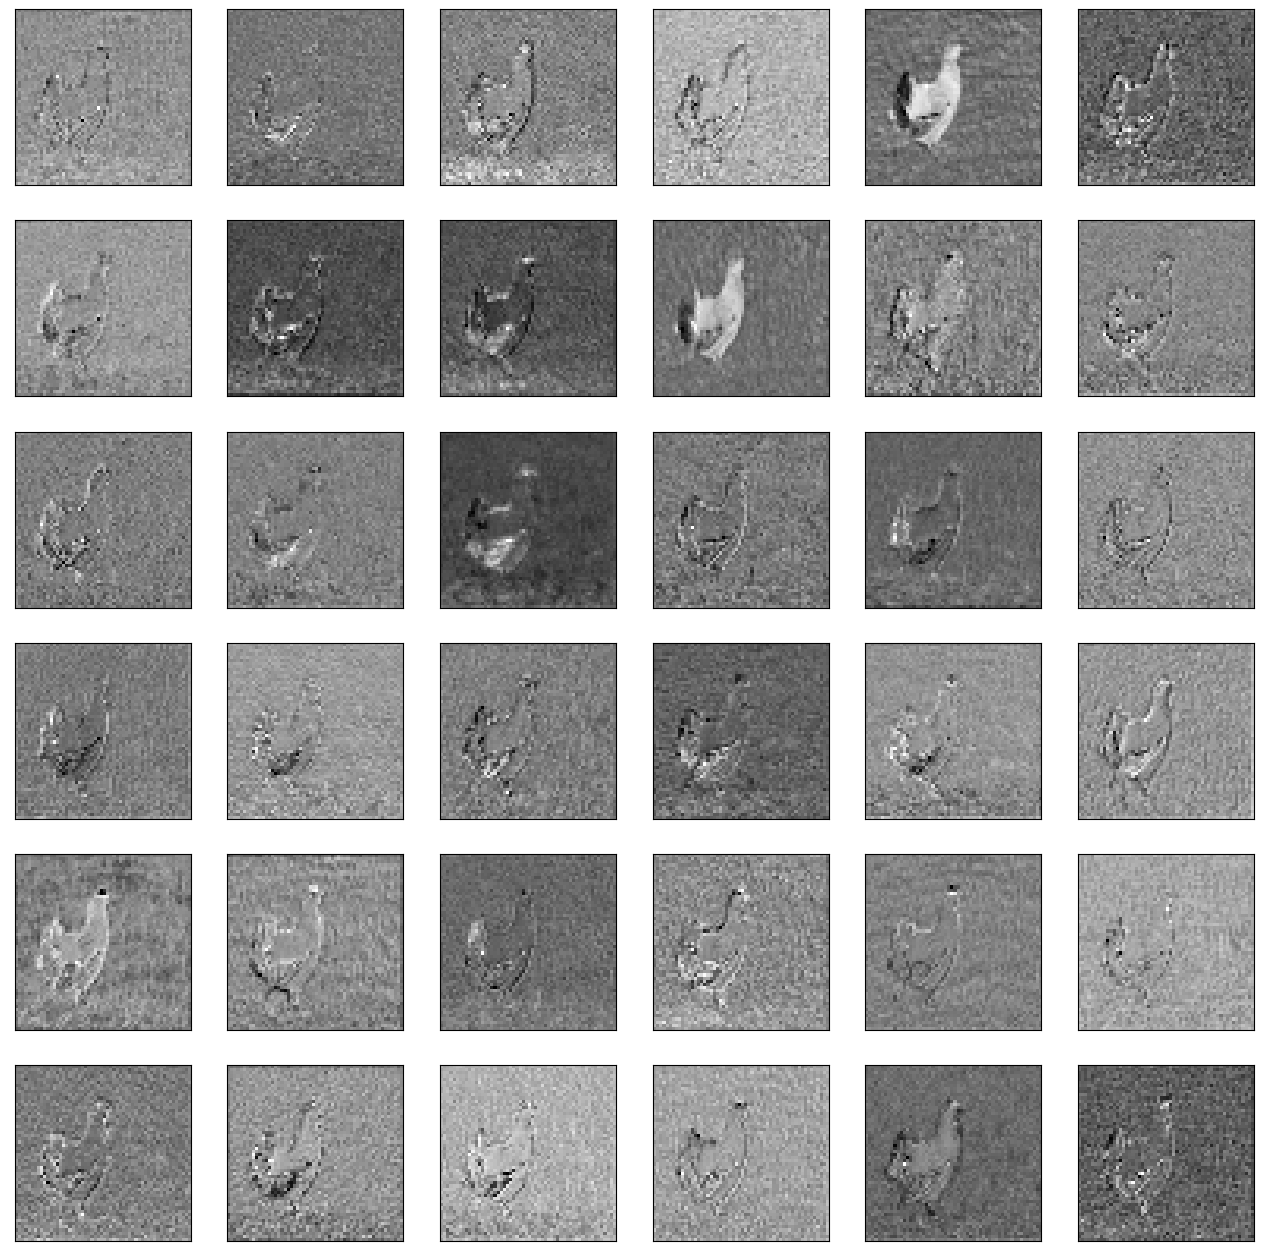

In [10]:
visualize_activations(model, model.stem.convs[6], img_path, device='gpu')

In [43]:
from visualizer_utils import preprocess_img, show_cam_on_image, deprocess_image, GuidedBackpropReLUModel, GradCam

img = cv2.imread(img_path, 1)
img = cv2.resize(img,(224,224))
img = np.float32(img) / 255

# Opencv loads as BGR:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
input_img = preprocess_img(img)
use_cuda=True

grad_cam = GradCam(model=model, feature_module=model.prediction,
                   target_layer_names=["4"], use_cuda=use_cuda)

# If None, returns the map for the highest scoring category.
# Otherwise, targets the requested category.
target_category = index
grayscale_cam = grad_cam(input_img, target_category)

grayscale_cam = cv2.resize(grayscale_cam, (img.shape[1], img.shape[0]))
cam = show_cam_on_image(img, grayscale_cam)

gb_model = GuidedBackpropReLUModel(model=model, use_cuda=use_cuda)
gb = gb_model(input_img, target_category=target_category)
gb = gb.transpose((1, 2, 0))

cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
cam_gb = deprocess_image(cam_mask*gb)
gb = deprocess_image(gb)

cv2.imwrite("cam.jpg", cam)
cv2.imwrite('gb.jpg', gb)
cv2.imwrite('cam_gb.jpg', cam_gb);

torch.Size([1, 1000, 7, 7])
(1, 1000)
temp:  torch.Size([1, 7, 7, 1000])
torch.Size([])


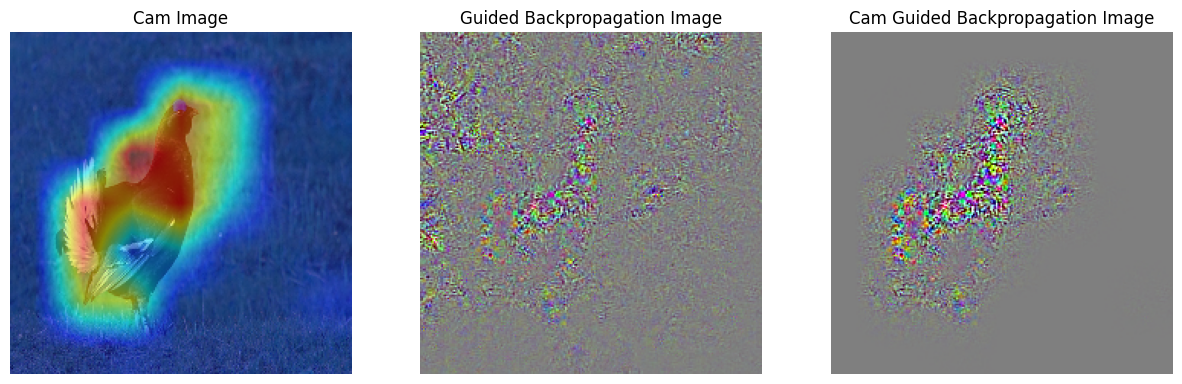

In [44]:
import matplotlib.pyplot as plt

cam_bgr = cv2.cvtColor(cam, cv2.COLOR_RGB2BGR)
img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[1].imshow(img_bgr)
axs[1].set_title('Raw Image')
axs[1].axis('off')

axs[0].imshow(cam_bgr)
axs[0].set_title('Cam Image')
axs[0].axis('off')

plt.show()